In [47]:
import sys
sys.path.append('../')

import os
import json
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial.transform import Rotation as R

DATA_PATH = "/dust3r/masked_dust3r/data/jackal_training_data_0"

with open(os.path.join(DATA_PATH, "transforms.json"), "r") as f:
    transforms = json.load(f)

[[ 7.36724503e+01  3.40082471e+01  1.36354450e+02]
 [ 7.53951359e+01  2.91010550e+01  1.41367459e+02]
 [ 7.81392234e+01  2.62999140e+01  1.48599563e+02]
 [ 7.98130618e+01  2.26044307e+01  1.54534870e+02]
 [ 8.15115452e+01  1.82227848e+01  1.59584087e+02]
 [ 8.36566640e+01  1.31394378e+01  1.65106916e+02]
 [ 8.57162320e+01  8.25802598e+00  1.70438694e+02]
 [ 8.59800895e+01  3.73798736e+00  1.75277749e+02]
 [ 8.59158338e+01 -1.33379576e+00 -1.77521393e+02]
 [ 8.54214860e+01 -7.19466063e+00 -1.74401335e+02]
 [ 8.46007258e+01 -1.20152154e+01 -1.68610193e+02]
 [ 8.23656754e+01 -1.69579043e+01 -1.60027201e+02]
 [ 7.92212078e+01 -2.15772270e+01 -1.54863714e+02]
 [ 7.50544670e+01 -2.37475184e+01 -1.48703487e+02]
 [ 6.96875431e+01 -2.76898623e+01 -1.44087399e+02]
 [ 6.92682447e+01 -3.15834977e+01 -1.37549209e+02]
 [ 6.74730589e+01 -3.52181535e+01 -1.31119050e+02]
 [ 6.22329661e+01 -3.73256112e+01 -1.21176785e+02]
 [ 5.69035045e+01 -4.05539829e+01 -1.12914586e+02]
 [ 5.13401984e+01 -4.22186882e+

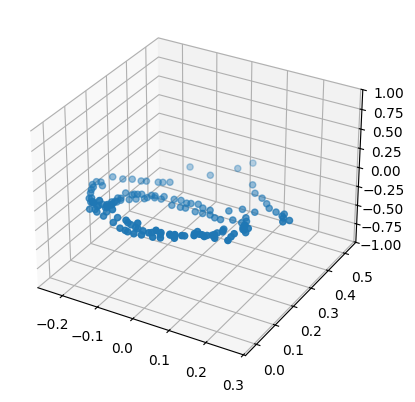

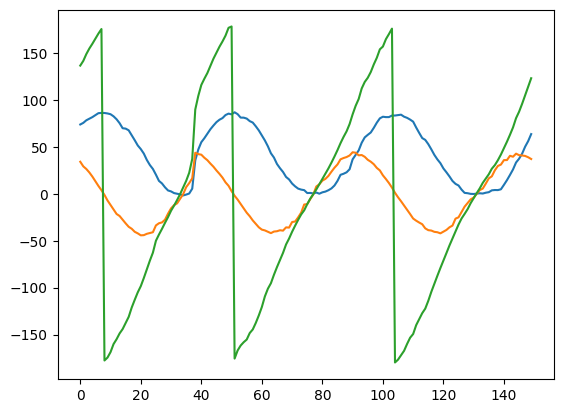

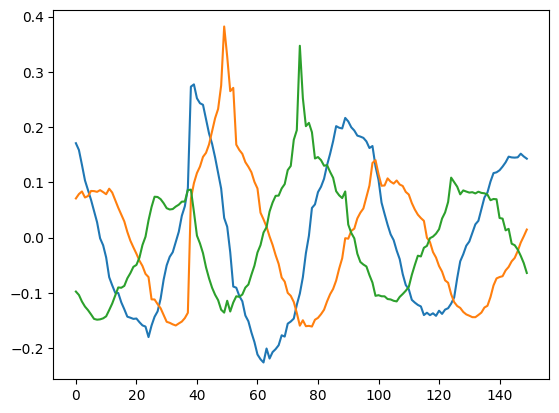

In [48]:

OPENGL = np.array([
    [1, 0, 0, 0],
    [0, -1, 0, 0],
    [0, 0, -1, 0],
    [0, 0, 0, 1]
])

points = []
euler_angle = []
for frame in transforms["frames"]:
    tf = np.array(frame["transform_matrix"])
    tf = np.dot(OPENGL,tf)
    points.append(tf[0:3, 3])
    r = R.from_matrix(tf[0:3, 0:3])
    euler_angle.append(r.as_euler('xyz', degrees=True))
    
points = np.array(points)
euler_angle = np.array(euler_angle)
print(euler_angle)

# Plot the points

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(points[:, 0], points[:, 1], points[:, 2])
#Set z-axis
ax.set_zlim(-1, 1)

# Plot the euler angles with respect to index
fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(euler_angle[:, 0], label="x")
ax.plot(euler_angle[:, 1], label="y")
ax.plot(euler_angle[:, 2], label="z")

# Plot the points with respect to index
fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(points[:, 0] - points[:,0].sum()/len(points[:,0]), label="x")
ax.plot(points[:, 1] - points[:,1].sum()/len(points[:,1]), label="y")
ax.plot(points[:, 2] - points[:,2].sum()/len(points[:,2]), label="z")

plt.show()

[[ 4.49771869e+01  0.00000000e+00  0.00000000e+00]
 [ 4.49771869e+01  0.00000000e+00  7.20000000e+00]
 [ 4.49771869e+01  0.00000000e+00  1.44000000e+01]
 [ 4.49771869e+01  0.00000000e+00  2.16000000e+01]
 [ 4.49771869e+01  0.00000000e+00  2.88000000e+01]
 [ 4.49771869e+01  0.00000000e+00  3.60000000e+01]
 [ 4.49771869e+01  0.00000000e+00  4.32000000e+01]
 [ 4.49771869e+01  0.00000000e+00  5.04000000e+01]
 [ 4.49771869e+01  0.00000000e+00  5.76000000e+01]
 [ 4.49771869e+01  0.00000000e+00  6.48000000e+01]
 [ 4.49771869e+01  0.00000000e+00  7.20000000e+01]
 [ 4.49771869e+01  1.27222187e-14  7.92000000e+01]
 [ 4.49771869e+01  0.00000000e+00  8.64000000e+01]
 [ 4.49771869e+01  0.00000000e+00  9.36000000e+01]
 [ 4.49771869e+01  0.00000000e+00  1.00800000e+02]
 [ 4.49771869e+01 -1.27222187e-14  1.08000000e+02]
 [ 4.49771869e+01  0.00000000e+00  1.15200000e+02]
 [ 4.49771869e+01  0.00000000e+00  1.22400000e+02]
 [ 4.49771869e+01  0.00000000e+00  1.29600000e+02]
 [ 4.49771869e+01  0.00000000e+

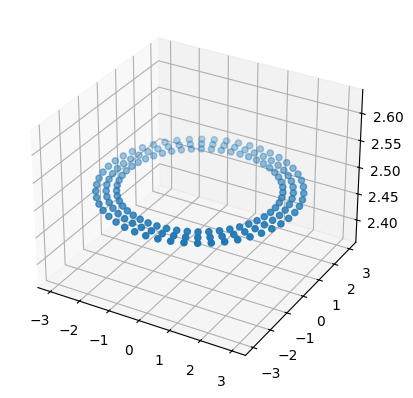

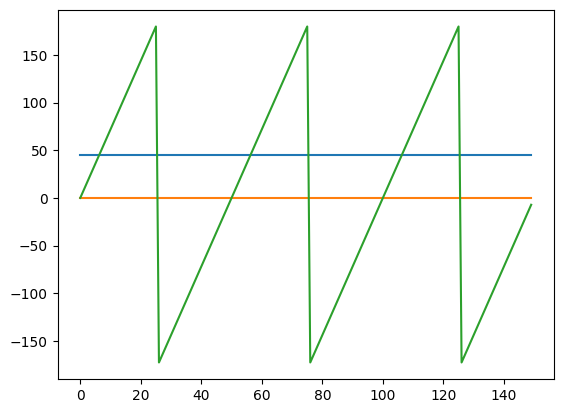

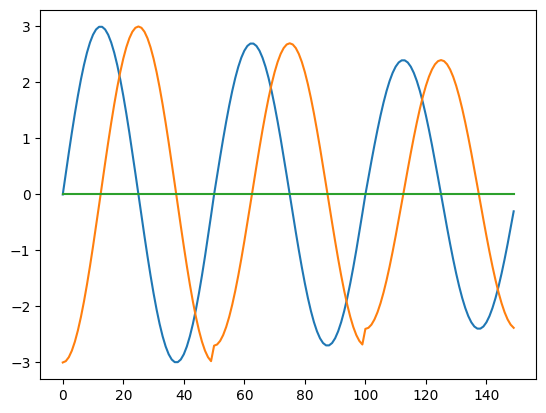

In [49]:
with open(os.path.join(DATA_PATH, "ground_truth.json"), "r") as f:
    ground_truth = json.load(f)
    
#transforms["frames"] = rotate_best_fit_plane(transforms["frames"])

ground_truth["frames"] = ground_truth["frames"][0:len(transforms["frames"])]

points = []
euler_angle = []
for frame in ground_truth["frames"]:
    tf = frame["transform_matrix"]
    tf = np.array(tf).reshape(4, 4)
    points.append(tf[0:3, 3])
    r = R.from_matrix(tf[0:3, 0:3])
    euler_angle.append(r.as_euler('xyz', degrees=True))

points = np.array(points)
euler_angle = np.array(euler_angle)
print(euler_angle)

# Plot the points

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(points[:, 0], points[:, 1], points[:, 2])

# Plot the euler angles with respect to index
fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(euler_angle[:, 0], label="x")
ax.plot(euler_angle[:, 1], label="y")
ax.plot(euler_angle[:, 2], label="z")

# Plot the points with respect to index
fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(points[:, 0] - points[:,0].sum()/len(points[:,0]), label="x")
ax.plot(points[:, 1] - points[:,1].sum()/len(points[:,1]), label="y")
ax.plot(points[:, 2] - points[:,2].sum()/len(points[:,2]), label="z")

plt.show()